In [74]:
import os, glob
import pandas as pd
import geopandas as gpd
import fiona
from shapely.geometry import shape, Polygon
import matplotlib.pyplot as plt


# Input / Output

## Input

In [102]:
gpx_path = '/export/projects/FAO-EOStat-Senegal/Assemble/'

odk_path = '/export/projects/FAO-EOStat-Senegal/FormSenegal05/'

odk_csv = f'{odk_path}FormSenegal05.csv'

## Output

In [110]:
gpx_shp = '/export/projects/FAO-EOStat-Senegal/Output_Nico/all_gpx.shp'

# GPX files

In [116]:

dict_gpx_list = []

for gpx_file in glob.glob(f'{gpx_path}*/*.gpx')[0:10]:

    filename = os.path.basename(gpx_file)
    print(filename)

    id = f'{filename[6:6+7]}{filename[14:15]}{filename[16:17]}{filename[18:19]}{filename[20:21]}'

    print(id)

    layer = fiona.open(gpx_file, layer='tracks')

    crs = layer.crs

    if crs['init'] == 'epsg:4326':

        dict_gpx = {'filename': filename,
                    'id': id,
                    'coordinates': layer[0]['geometry']['coordinates'][0]}

        dict_gpx_list.append(dict_gpx)

#dict_gpx_list


Piste_6220102-2-4-1-1.gpx
62201022411
Piste_6220102-2-4-1-2.gpx
62201022412
Piste_6220102-2-4-1-3.gpx
62201022413
Piste_6220102-2-4-1-4.gpx
62201022414
Piste_6220102-2-16-4.gpx
622010221-.
Piste_6220102-2-16-5-1.gpx
622010221--
Piste_6220102-2-16-5-2.gpx
622010221--
Piste_6220102-2-16-5-3.gpx
622010221--
Piste_6220102-2-33-3-1.gpx
622010223--
Piste_6220102-2-4-1-1.gpx
62201022411


In [108]:
df = pd.DataFrame.from_dict(dict_gpx_list)

df['geometry'] = df.coordinates.apply(Polygon)

df = df.drop('coordinates', axis=1)

gdf = gpd.GeoDataFrame(df, crs='epsg:4326', geometry='geometry')

gdf['geometry'] = gdf.buffer(0)

gdf

,filename,id,geometry
0,Piste_6220102-2-4-1-1.gpx,62201022411,"POLYGON ((-15.65158 13.71486, -15.65157 13.714..."
1,Piste_6220102-2-4-1-2.gpx,62201022412,"POLYGON ((-15.64866 13.71411, -15.64868 13.714..."
2,Piste_6220102-2-4-1-3.gpx,62201022413,"POLYGON ((-15.64766 13.71621, -15.64765 13.716..."
3,Piste_6220102-2-4-1-4.gpx,62201022414,"POLYGON ((-15.64763 13.71488, -15.64762 13.714..."
4,Piste_6220102-2-16-4.gpx,622010221-.,"POLYGON ((-15.64915 13.70645, -15.64915 13.706..."
...,...,...,...
869,Piste_6220206-7-7-2-2.gpx,62202067722,"POLYGON ((-15.70609 13.85070, -15.70609 13.850..."
870,Piste_6220206-7-7-2-3.gpx,62202067723,"POLYGON ((-15.69301 13.85112, -15.69309 13.851..."
871,Piste_6220206-7-7-2-4.gpx,62202067724,"POLYGON ((-15.69084 13.84977, -15.69084 13.849..."
872,Piste_6220206-7-7-2-5.gpx,62202067725,"POLYGON ((-15.69073 13.85019, -15.69074 13.850..."


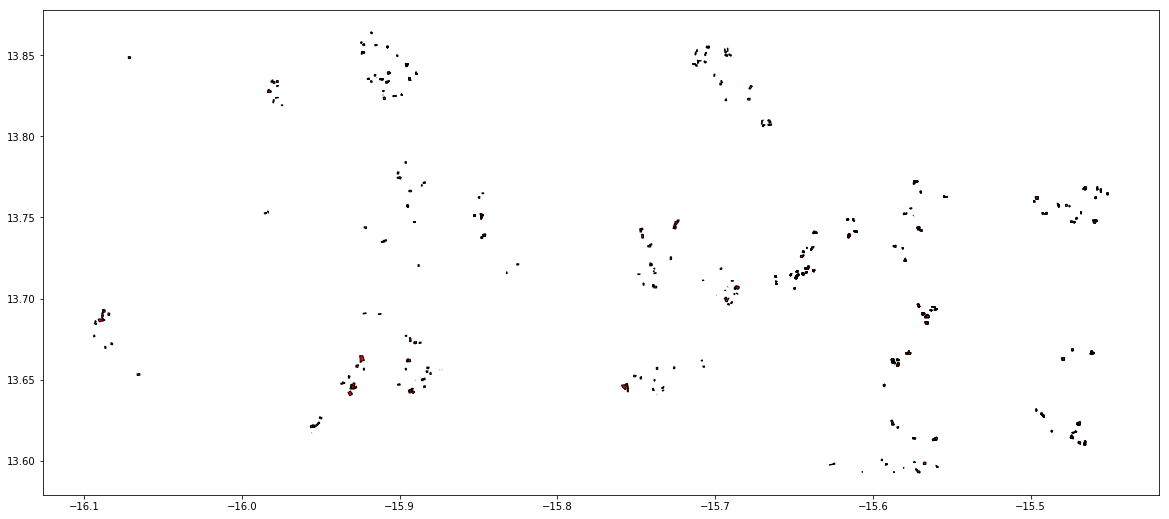

In [101]:
fig, ax = plt.subplots(1, figsize=(20, 20))

gdf.plot(facecolor='red', edgecolor='black',ax=ax)

In [111]:
gdf.to_file(filename=gpx_shp, driver='ESRI Shapefile')

# ODK

In [113]:
odk_df = pd.read_csv(odk_csv)

for col in odk_df.columns:
    print(col)

SubmissionDate
start
end
today
start-geopoint-Latitude
start-geopoint-Longitude
start-geopoint-Altitude
start-geopoint-Accuracy
deviceid
id-Commune
id-Commune_autre
id-District
id-District_autre
id-Concession
id-Concession_autre
id-Menage
id-Mengae_autre
id-Parcelle
id-Parcelle_autre
Informations_champ-Melange
Informations_champ-Culture
Informations_champ-Culture_autre
Informations_champ-Culture2
Informations_champ-Culture_autre2
Informations_champ-Culture3
Informations_champ-Culture_autre3
Informations_champ-Proportion
Informations_champ-Homogene
Informations_champ-Photo
Informations_champ-Herbe
Informations_champ-polygone
Informations_champ-Surface
Informations_champ-Surface_arrondie
Informations_champ-Surface_note
Informations_rendement-Carre
Informations_rendement-YorN
Informations_rendement-Coordonee_carre-Latitude
Informations_rendement-Coordonee_carre-Longitude
Informations_rendement-Coordonee_carre-Altitude
Informations_rendement-Coordonee_carre-Accuracy
OTH-Comment
meta-instan

## Create ID from ODK csv

In [120]:
odk_df['id'] = odk_df['id-Commune'].astype(str) + odk_df['id-District'].astype(str) + odk_df['id-Concession'].astype(str) + odk_df['id-Menage'].astype(str) + odk_df['id-Parcelle'].astype(str)

odk_df['id']

0      6220201174341
1      6220201173222
2      6220201171611
3      6220201171631
4      6220201171661
           ...      
231     622020557136
232     622020557134
233     622020557134
234     622020557152
235     622020557131
Name: id, Length: 236, dtype: object

## Select usefull fields

In [121]:
odk_df_subset = odk_df[['id','Informations_champ-Melange','Informations_champ-Culture','Informations_champ-Surface']]

odk_df_subset

,id,Informations_champ-Melange,Informations_champ-Culture,Informations_champ-Surface
0,6220201174341,1,1.0,31297.986337
1,6220201173222,1,13.0,9618.217668
2,6220201171611,1,1.0,17649.581646
3,6220201171631,1,1.0,10117.531243
4,6220201171661,1,1.0,7216.510582
...,...,...,...,...
231,622020557136,1,1.0,7939.164175
232,622020557134,1,11.0,11876.578849
233,622020557134,1,11.0,8226.201945
234,622020557152,1,11.0,5210.138491
